In [1]:
import pandas as pd
import numpy as np
from ipywidgets import interact
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from zipfile import ZipFile

In [2]:
# Load the data
def load_data(path):
    dataframes = {}

    with ZipFile(path) as archive:
        with archive.open('campaign_desc.csv') as f:
            dataframes['campaign_desc'] = pd.read_csv(f)
            
        with archive.open('campaign_table.csv') as f:
            dataframes['campaign_table'] = pd.read_csv(f)
        
        with archive.open('causal_data.csv') as f:
            dataframes['causal_data'] = pd.read_csv(f)
        
        with archive.open('coupon.csv') as f:
            dataframes['coupon'] = pd.read_csv(f)
        
        with archive.open('coupon_redempt.csv') as f:
            dataframes['coupon_redempt'] = pd.read_csv(f)
            
        with archive.open('hh_demographic.csv') as f:
            dataframes['hh_demographic'] = pd.read_csv(f)
        
        with archive.open('product.csv') as f:
            dataframes['product'] = pd.read_csv(f)
            
        with archive.open('transaction_data.csv') as f:
            dataframes['transaction_data'] = pd.read_csv(f)
        
    return dataframes

def data_missing(dataframes):
    any_missing_data = False

    for (name, dataframe) in dataframes.items():
        any_missing_data = any_missing_data | dataframe.isna().values.any()

    return any_missing_data


In [110]:
dataframes = load_data('ProjectData/dunnhumby.zip')

In [4]:
# Get the dataframe that contains information regarding the living status of a person
demographic_df = dataframes['hh_demographic']

# Transform the status to lowercase string in order
demographic_df['HOMEOWNER_DESC'] = demographic_df['HOMEOWNER_DESC'].apply(lambda s: s.lower())

# There are some fileds in HOMEOWNER_DESC that have the `Probably` word inside so we check inf the string contains owner/ renter
home_owner_df = demographic_df[demographic_df['HOMEOWNER_DESC'].str.contains('owner')]
renter_df = demographic_df[demographic_df['HOMEOWNER_DESC'].str.contains('renter')]

In [5]:
print('NaN Data: %r' % data_missing(dataframes))
dataframes['hh_demographic'].head()

NaN Data: False


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,homeowner,Single Female,1,None/Unknown,16


<font color = "green">

As we can see we do not have any **NaN** data, so we do not have to worry about preprocessing, but we have indeed values that have the **Unknown** string instead of something valid. For this type of missing data we will not use lines that are marked with **Unknown** when creating the statistics since we depend on knowing the status of the person (renter/ owenr; married/ unmarried)

In [111]:
dataframes['product']['DEPARTMENT'].unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

<font color = "green">
    
Inspecting the `product` dataframe we see that there is a department name that contains only on space. Let's print it to see if it has relevant information

In [112]:
dataframes['product'][dataframes['product']['DEPARTMENT'].apply(lambda e: len(e)) == 1]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
52189,5126087,1,,National,,,
52190,5126088,1,,National,,,
52191,5126106,1,,National,,,
52192,5126107,1,,National,,,
55048,5977100,1,,National,,,
55054,5978648,1,,National,,,
55055,5978649,1,,National,,,
55056,5978650,1,,National,,,
55057,5978656,1,,National,,,
55058,5978657,1,,National,,,


<font color = "green">
    
The above dataframe contains only 15 entries that do not tell anything, so we remove them.

In [113]:
dataframes['product'] = dataframes['product'][dataframes['product']['DEPARTMENT'].apply(lambda e: len(e)) > 1]

In [114]:
dataframes['product']['DEPARTMENT'].unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

# 1. How living status of a person (owner or renter, married or unmaried) influences the buying habits?

## Owner and renter

In [6]:
salary_ranges = list(demographic_df['INCOME_DESC'].unique())
age_ranges = list(demographic_df['AGE_DESC'].unique())

age_ranges.sort(key = lambda e: int(e.split('-')[0]) if len(e.split('-')[0]) == 2 else \
                        int(e.split('-')[0][: -1]))
salary_ranges.sort(key = lambda e: 0 if e.split('-')[0][0] == 'U' else \
                       int(e.split('-')[0][: -2] if len(e.split('-')) == 1 else \
                       int(e.split('-')[0])))

### Salary distribution per age ranges

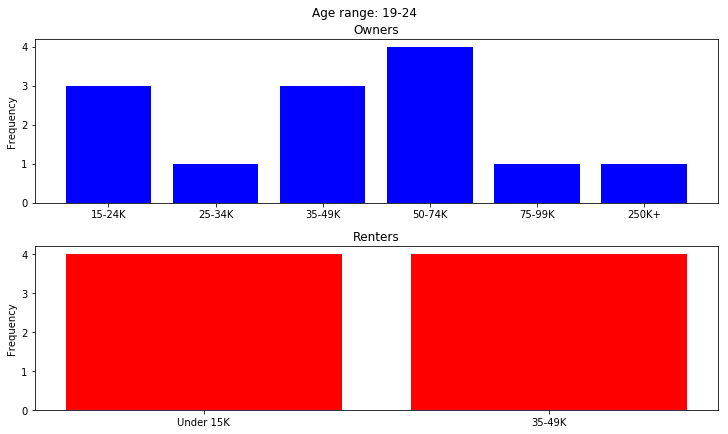

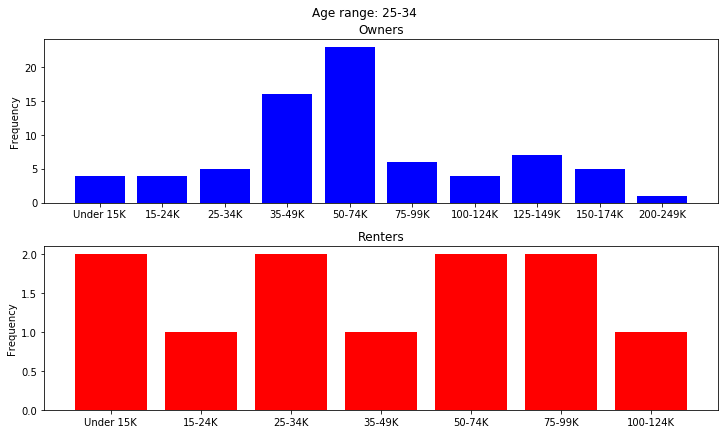

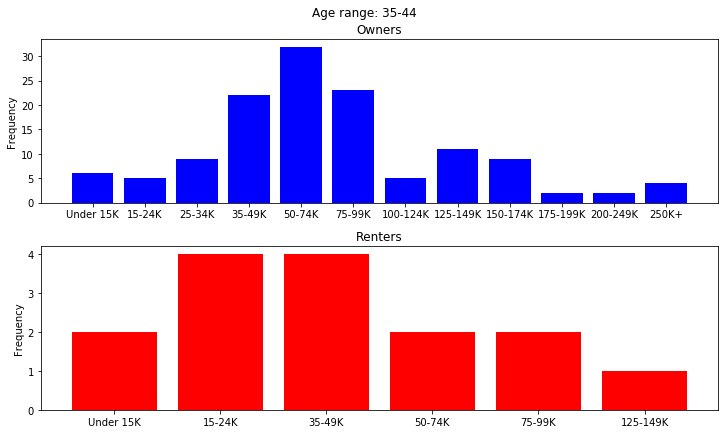

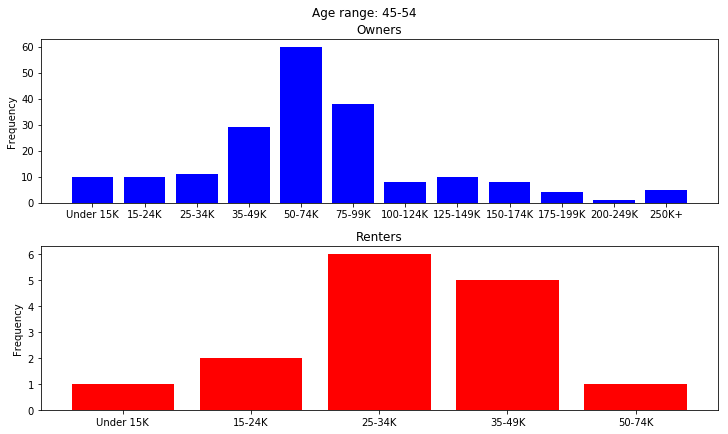

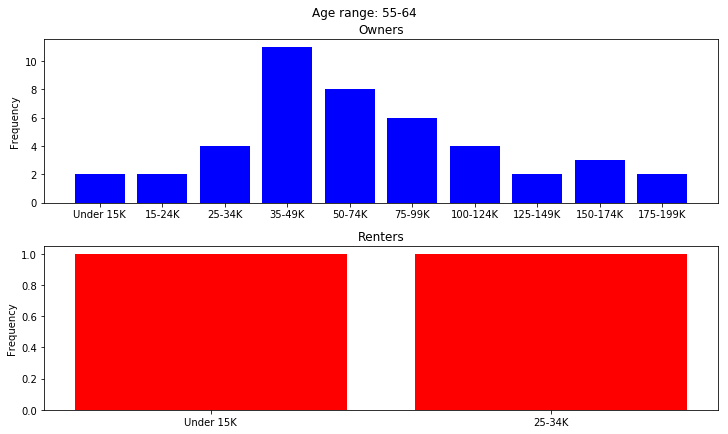

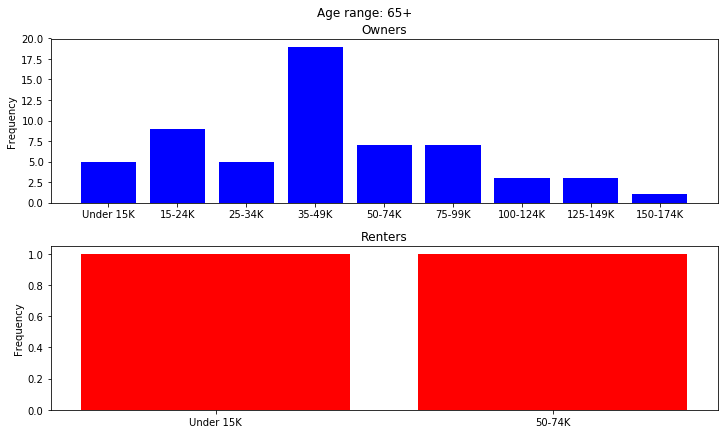

In [7]:
salary_distribution_owners = home_owner_df.groupby(['AGE_DESC', 'INCOME_DESC']).size()
salary_distribution_renters = renter_df.groupby(['AGE_DESC', 'INCOME_DESC']).size()

for age in age_ranges:
    fig, (ax1, ax2) = plt.subplots(2, constrained_layout = True, figsize = [10, 6])
    items_owners = list(salary_distribution_owners[age].items())
    items_renters = list(salary_distribution_renters[age].items())
    
    items_owners.sort(key = lambda e: 0 if e[0].split('-')[0][0] == 'U' else \
                       int(e[0].split('-')[0][: -2] if len(e[0].split('-')) == 1 else \
                       int(e[0].split('-')[0])))
    items_renters.sort(key = lambda e: 0 if e[0].split('-')[0][0] == 'U' else \
                       int(e[0].split('-')[0][: -2] if len(e[0].split('-')) == 1 else \
                       int(e[0].split('-')[0])))

    x_pos_owners = np.arange(len(items_owners))
    x_pos_renters = np.arange(len(items_renters))
    
    ax1.bar(x = x_pos_owners, height = [e[1] for e in items_owners], color = 'blue', tick_label = [e[0] for e in items_owners])
    ax1.set_title('Owners')
    ax1.set_ylabel('Frequency')
    
    ax2.bar(x = x_pos_renters, height = [e[1] for e in items_renters], color = 'red', tick_label = [e[0] for e in items_renters])
    ax2.set_title('Renters')
    ax2.set_ylabel('Frequency')
    
    fig.suptitle('Age range: %s' % age)
    
    plt.show()

<font color = "green">

Most of the people are owners and by looking at every age category we observe that the salaries are normally distributed. We expect to see that the average value of products baught by owners to be a little higher than the average value of products of renters

### Average price per transaction for all age ranges

In [8]:
owners_transactions_df = pd.merge(home_owner_df, dataframes['transaction_data'], how = 'inner', on = 'household_key')
renters_transactions_df = pd.merge(renter_df, dataframes['transaction_data'], how = 'inner', on = 'household_key')

owners_transactions_df['TRANSACTION_VALUE'] = owners_transactions_df['SALES_VALUE'] - \
                                            (owners_transactions_df['RETAIL_DISC'] + \
                                             owners_transactions_df['COUPON_MATCH_DISC'])
renters_transactions_df['TRANSACTION_VALUE'] = renters_transactions_df['SALES_VALUE'] - \
                                            (renters_transactions_df['RETAIL_DISC'] + \
                                             renters_transactions_df['COUPON_MATCH_DISC'])

owners_prices_per_age = owners_transactions_df.groupby('AGE_DESC')['TRANSACTION_VALUE'].mean()
renters_prices_per_age = renters_transactions_df.groupby('AGE_DESC')['TRANSACTION_VALUE'].mean()

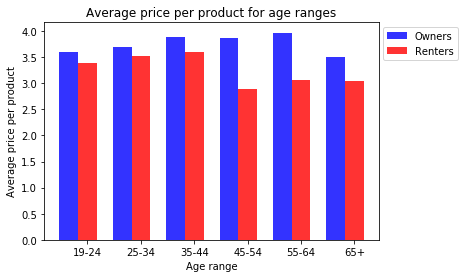

In [72]:
fig, ax = plt.subplots()
index = np.arange(owners_prices_per_age.shape[0])
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, [e[1] for e in owners_prices_per_age.items()], \
                 bar_width, alpha = opacity, color = 'blue', label = 'Owners')
rects2 = plt.bar(index + bar_width, [e[1] for e in renters_prices_per_age.items()], \
                 bar_width, alpha = opacity, color='red', label = 'Renters')

plt.xticks(index + bar_width, [e[0] for e in owners_prices_per_age.items()])
plt.xlabel('Age range')
plt.ylabel('Average price per product')
plt.title('Average price per product for age ranges')
ax.legend(bbox_to_anchor=(1.25, 1.0))
plt.show()


In [10]:
print('Number of owners: %d' % home_owner_df.shape[0])
print('Number of renters: %d' % renter_df.shape[0])

Number of owners: 515
Number of renters: 53


<font color = "green">

Indeed, we can see that owners tend to spend more money on products on all age ranges. It is worth noticing that this might be biased due to very big difference in numbers of between renteres and owners. **Renters represent aproximatively 10% of the total number of owners.**

### Influence of coupons over renters and owners

In [11]:
# Obtain the coupons redempt by both renters and owners
coupons_redempt_owners = pd.merge(dataframes['coupon_redempt'], home_owner_df, how = 'inner', on = ['household_key'])
coupons_redempt_renters = pd.merge(dataframes['coupon_redempt'], renter_df, how = 'inner', on = ['household_key'])

Text(0, 0.5, 'Number of coupons')

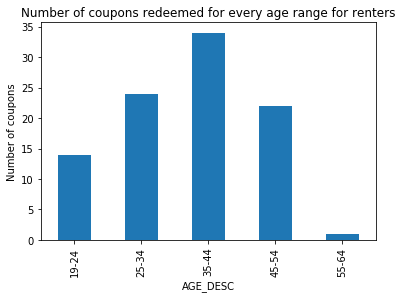

In [12]:
ax = coupons_redempt_renters.groupby('AGE_DESC').size().plot.bar()
ax.set_title('Number of coupons redeemed for every age range for renters')
ax.set_ylabel('Number of coupons')

Text(0, 0.5, 'Number of coupons')

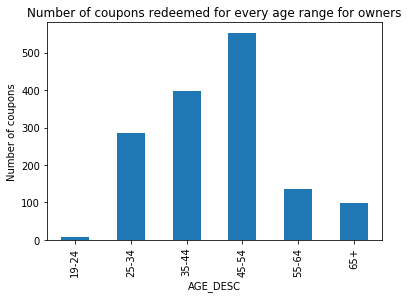

In [13]:
ax = coupons_redempt_owners.groupby('AGE_DESC').size().plot.bar()
ax.set_title('Number of coupons redeemed for every age range for owners')
ax.set_ylabel('Number of coupons')

<font color = "green">
    
* It is not worth comparing the number of coupons, because as we can see, the owners are more than the renters. We need to look for an explanation why the number of redempt coupons is greater for the owners with age between 25-54 years old.
* There might be some reasons for that:
    - most of the people between 25-54 years old are married and they redeem more coupons than people from different age ranges
    - they get more coupon compared to the others

We will investigate the reason

In [14]:
# Merge dataframe of owners with `campaign_table` to see how many coupons the owner received
types_of_coupons_redempt_owners = pd.merge(home_owner_df, dataframes['campaign_table'], how = 'inner', on = 'household_key')
types_of_coupons_redempt_owners = types_of_coupons_redempt_owners.groupby(['AGE_DESC', 'DESCRIPTION']).size()

# Merge dataframe of owners with `campaign_table` to see how many coupons the renters received
types_of_coupons_redempt_renters = pd.merge(renter_df, dataframes['campaign_table'], how = 'inner', on = 'household_key')
types_of_coupons_redempt_renters = types_of_coupons_redempt_renters.groupby(['AGE_DESC', 'DESCRIPTION']).size()

In [15]:
def plot_number_of_coupons_received(series, xlabel, ylabel, title, age_ranges):
    campaigns_type_a, campaigns_type_b, campaigns_type_c  = [], [], []

    for age_range in age_ranges:
        if 'TypeA' in series[age_range]:
            campaigns_type_a.append(series[age_range]['TypeA'])
        else:
            campaigns_type_a.append(0)

        if 'TypeB' in series[age_range]:
            campaigns_type_b.append(series[age_range]['TypeB'])
        else:
            campaigns_type_b.append(0)

        if 'TypeC' in series[age_range]:
            campaigns_type_c.append(series[age_range]['TypeC'])
        else:
            campaigns_type_c.append(0)

    fig, ax = plt.subplots()
    index = np.arange(len(campaigns_type_a))
    bar_width = 0.3
    opacity = 0.8

    rects_campagin_a = plt.bar(index, campaigns_type_a, bar_width, alpha = opacity, color = 'blue', label = 'Campaigns TypeA')
    rects_campagin_b = plt.bar(index + bar_width, campaigns_type_b, bar_width, alpha = opacity, color = 'red', \
                               label = 'Campaigns TypeB')
    rects_campagin_c = plt.bar(index + 2 * bar_width, campaigns_type_c, bar_width, alpha = opacity, color = 'green', \
                               label = 'Campaigns TypeC')

    plt.xticks(index + bar_width, age_ranges)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

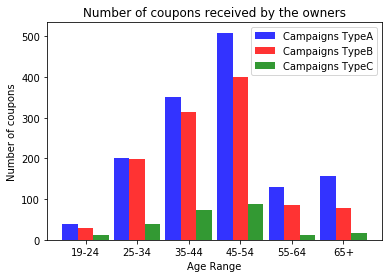

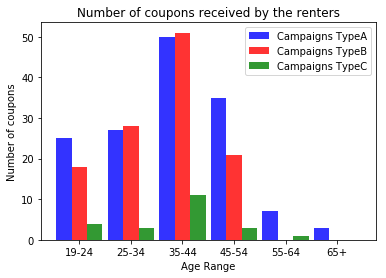

In [16]:
plot_number_of_coupons_received(types_of_coupons_redempt_owners, 'Age Range', 'Number of coupons', \
                                'Number of coupons received by the owners', age_ranges)
plot_number_of_coupons_received(types_of_coupons_redempt_renters, 'Age Range', 'Number of coupons', \
                                'Number of coupons received by the renters', age_ranges)

<font color = "green">

* Looking at the 2 plots from above we see that the people from the age ranges that redeemed the most tickets received indeed more tickets. This leads us to thinking that people with ages between 25-54 participated indeed more frequently in campaign in order to get discounts regardless if they are renters or owners.
* Now let's look at what kind of people redeemed the coupons and for what kind of products

### What kind of people redeemed the coupons and on what kind of products

<font color = "green">

We will look a little bit more in depth on how people with ages between 25-54 years old spent the coupons

In [130]:
df = dataframes['hh_demographic']
people = df
coupons_redeemed = pd.merge(people, dataframes['coupon_redempt'], how = 'inner', on = 'household_key')

<font color = "green">

We will look on the distribution of coupons redemeed depending on the family composition of these people.

Text(0.5, 1.0, 'Distribution of coupons redeemed')

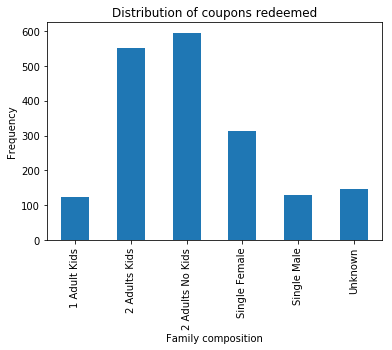

In [179]:
ax = coupons_redeemed.groupby('HH_COMP_DESC').size().plot.bar()
ax.set_xlabel('Family composition')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of coupons redeemed')

<font color = "green">

* Indeed, we can see in the above plot that families that have kids redeem more coupons (looking at the bar with with **1 Adult Kids** and **2 Adults Kids**).
* What seems interesting is that families with 2 adults redeem more coupons than families with 2 adults that have kids.

### What kind of products buy different types of people

In [132]:
# Dataframe with all the transactions
transactions_df = pd.merge(people, dataframes['transaction_data'], how = 'inner', on = 'household_key')
transactions_products_df = pd.merge(transactions_df, dataframes['product'], how = 'inner', on = 'PRODUCT_ID')

<font color = "green">

* Let's look at buying habbits of people depending on the family composition for the most basi products like: groceries, meat, seafood, medicines and nutrition

In [168]:
groceries = transactions_products_df[transactions_products_df['DEPARTMENT'].\
                                     isin(['GROCERY', 'PASTRY', 'GRO BAKERY', 'PASTRY', \
                                           'FROZEN GROCERY'])].groupby('HH_COMP_DESC').size()
meat = transactions_products_df[transactions_products_df['DEPARTMENT'].\
                                isin(['MEAT-PCKGD', 'MEAT', 'MEAT-WHSE', 'PORK'])].\
                                groupby('HH_COMP_DESC').size()
seafood = transactions_products_df[transactions_products_df['DEPARTMENT'].\
                                isin(['SEAFOOD-PCKGD', 'SEAFOOD'])].groupby('HH_COMP_DESC').size()
medicines = transactions_products_df[transactions_products_df['DEPARTMENT'].\
                                isin(['DRUG GM', 'PHARMACY SUPPLY'])].groupby('HH_COMP_DESC').size()

In [174]:
def plot_bar_series(series, xlabel, ylabel, title):
    ax = series.plot.bar()
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    plt.show()

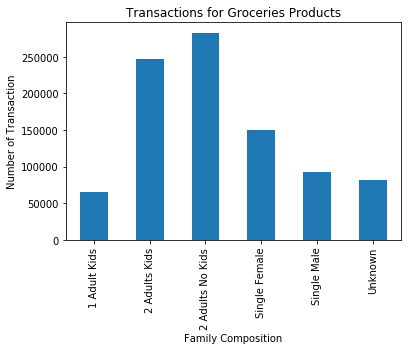

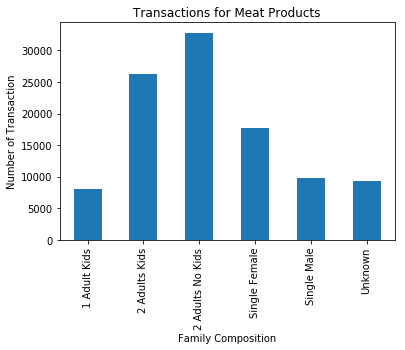

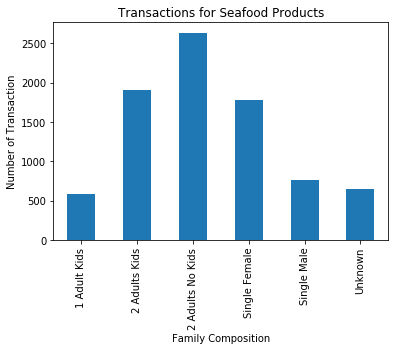

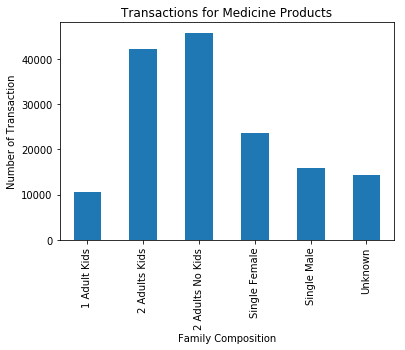

In [178]:
plot_bar_series(groceries, 'Family Composition', 'Number of Transaction', \
                'Transactions for Groceries Products')
plot_bar_series(meat, 'Family Composition', 'Number of Transaction', \
                'Transactions for Meat Products')
plot_bar_series(seafood, 'Family Composition', 'Number of Transaction', \
                'Transactions for Seafood Products')
plot_bar_series(medicines, 'Family Composition', 'Number of Transaction', \
                'Transactions for Medicine Products')

<font color = "green">
    
* As we can see, people buy mostly groceries.
* Looking at the families with kids (**1 Adult Kids** and **2 Adults Kids**) we see that family people tend to buy more than others. This is due to a higher need for food or medicines caused by a higher number of family members.